# Experiments with torchfm, which has a range of models based on FM (Factorization Machines). 
* None of these models are sequence-aware.
* Anaconda context must be set to "base". Eventually work with poetry.
* Try working with wandb (Weights & Biases)
* Starting with my_fm_copy.ipynb on July 21, 2021, integrate with elements of the code I wrote for rankfm. Specifically, I will read the data with the newlib.py library. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchfm
from torchfm import layer as fm_layer, model as fm_model
from torchfm.model import fm, lr, nfm, wd
import torch.nn.functional as F
import pandas as pd
import pandas_options
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
tt = torch.tensor
import numpy as np
# import tqdm
import random
import matplotlib.pyplot as plt
import myfunclib as myfm
import d2l_torch as d2l
import datalib
import wandb

In [3]:
from fastcore.all import L, AttrDict

In [4]:
#wandb.init(project="my-test-project")

In [5]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 128
}

wandb.log({"loss": loss})

# Optional
wandb.watch(model)

NameError: name 'loss' is not defined

In [6]:
device = d2l.try_gpu()
print(device)

cuda:0


In [7]:
gdct = {
    'device': device,  # 'cpu'
    'embed_dim': 10,
    'nb_epochs': 100,
    'lr': 0.05,
    'wd': 1.e-5,
    'optim': 'adamW',
    'batch_size' : 4096
}

In [8]:
gdct['device'] = 'cpu'

In [383]:
%%time 
in_file = "activity_reduced_with_attributes.csv"
dct = datalib.read_data_attributes_single_file(in_file, dct=AttrDict(), continuous_attrib=True)
dct.keys()

df_item_attrib columns:  ['D', 'avg_yr_l', 'avg_yr_h', 'IATA', 'LAT_DEC', 'LON_DEC', 'HEIGHT']
df_item_attrib shape:  (91, 7)
df_:  Index(['MEMBER_ID', 'D', 'age_departure', 'GENDER', 'avg_yr_l', 'avg_yr_h',
       'LAT_DEC', 'LON_DEC', 'HEIGHT'],
      dtype='object')
SHOULD NOT CREATE user_attrib_idx and item_attrib_idx manually! SHOULD DO THIS BEFORE CALL TO this method
CPU times: user 1.17 s, sys: 19.4 ms, total: 1.19 s
Wall time: 1.19 s


dict_keys(['age_cuts', 'df_members', 'df_with_attrib', 'user_attrib_idx', 'item_attrib_idx', 'user_attrib_str', 'item_attrib_str', 'field_types', 'field_dims'])

In [384]:
dct.item_attrib_str, dct.user_attrib_str

((#6) ['D','avg_yr_l','avg_yr_h','LAT_DEC','LON_DEC','HEIGHT'],
 (#3) ['MEMBER_ID','age_departure','GENDER'])

In [385]:
def convert_cat_variables(dct):
    idx2member, member2idx = datalib.cat2dict(dct['df_with_attrib']['MEMBER_ID'])
    idx2dest, dest2idx = datalib.cat2dict(dct['df_with_attrib']['D'])
    idx2gender, gender2idx = datalib.cat2dict(dct.df_with_attrib.GENDER)
    
    dct['idx2member'] = idx2member
    dct['member2idx'] = idx2member
    dct['idx2dest'] = idx2dest
    dct['dest2idx'] = dest2idx
    dct['idx2gender'] = idx2gender
    dct.gender2idx = gender2idx
    
    df1 = dct['df_with_attrib'].copy()
    df1['MEMBER_ID'] = df1['MEMBER_ID'].map(member2idx)
    df1['D'] = df1['D'].map(dest2idx)
    df1['GENDER'] = df1.GENDER.map(gender2idx)
    print("nb dest: ", len(dest2idx))
    print("nb members: ", len(idx2member))
    return df1

In [174]:
dct.keys()

dict_keys(['age_cuts', 'df_members', 'df_with_attrib', 'user_attrib_idx', 'item_attrib_idx', 'user_attrib_str', 'item_attrib_str', 'field_types', 'field_dims'])

In [386]:
df1 = convert_cat_variables(dct)
dct['df_with_attrib'] = df1

nb dest:  86
nb members:  46321


In [522]:
%%time 
# split data into train / valid / test data sets
datalib.train_valid_dct(dct, 0.6, 0.2, temporal=True, shuffle=True)
dataset_train = datalib.myDataset_neg(dct, dct.data_train)
dataset_train.gen_neg_samples()
dct.keys()

(804187, 9)
CPU times: user 2.4 s, sys: 101 ms, total: 2.5 s
Wall time: 2.4 s


dict_keys(['age_cuts', 'df_members', 'df_with_attrib', 'user_attrib_idx', 'item_attrib_idx', 'user_attrib_str', 'item_attrib_str', 'field_types', 'field_dims', 'idx2member', 'member2idx', 'idx2dest', 'dest2idx', 'idx2gender', 'gender2idx', 'data_train', 'data_valid', 'data_test'])

In [523]:
%%time
dataset_train.gen_user_attributes()

CPU times: user 37 ms, sys: 0 ns, total: 37 ms
Wall time: 36.6 ms


In [549]:
%%time
for i in range(4*4096):
    x = dataset_train[i]
    #print("===================================================")
    for j in range(len(x)):
        #print(x[j])
        pass
    # print(x)

CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 166 ms


In [550]:
loader = DataLoader(dataset_train, shuffle=True, batch_size=4*4096)

In [551]:
%%time
for i, load in enumerate(loader):  # 1.5 sec epr batch of 4096
    #print("done")
    if i == 1:
        break

CPU times: user 508 ms, sys: 800 µs, total: 509 ms
Wall time: 407 ms


In [364]:
dataset_train.gen_neg_samples()

m.shape:  (152796, 3)
m.shape:  (152796, 5)
neg/pos shape:  (152796, 8) (152796, 7)


In [265]:
%%time
dataset_train = datalib.myDataset(dct, dct.data_train)
dataset_train.gen_neg_samples()
# dataset_valid = datalib.myDataset(dct, dct.data_valid)
# dataset_test  = datalib.myDataset(dct, dct.data_test)

AttributeError: 'myDataset' object has no attribute 'member_D'

In [434]:
a = [3, 6, 7, 2, 3]
np.random.choice(a)
df = pd.DataFrame({'a': [1,2,3], 'b': [3,5,6]})
tt(df.values)

tensor([[1, 3],
        [2, 5],
        [3, 6]])

In [680]:
dct.batch_size = 64

dict_keys(['age_cuts', 'df_members', 'df_with_attrib', 'field_types', 'field_dims', 'data_train', 'data_valid', 'data_test', 'batch_size'])

In [614]:
loader_train = DataLoader(dataset_train, shuffle=True, batch_size=dct.batch_size)
loader_valid = DataLoader(dataset_valid, shuffle=True, batch_size=dct.batch_size)
loader_test  = DataLoader(dataset_test,  shuffle=True, batch_size=dct.batch_size)

In [615]:
dataset_train[3]

[ 2.83600000e+03  2.00000000e+00  5.74594595e+01  0.00000000e+00
  7.50000000e-01  8.80000000e-01  9.07100000e-02 -7.93830000e-01
  1.49306790e-02]


tensor([ 2.8360e+03,  2.0000e+00,  5.7459e+01,  0.0000e+00,  7.5000e-01,
         8.8000e-01,  9.0710e-02, -7.9383e-01,  1.4931e-02],
       dtype=torch.float64)

## DataLoader is functional

# NOT USED
batch_size = dct.batch_size
files = "attrib_2016.csv.gz"
#data_dict = myfm.getData(files, batch_size=batch_size, nrows='all')
data_dict = myfm.getData(files, batch_size=batch_size, nrows=20000, shuffle=False)
data_dict



data_dict['train_iter'].dataset.df.shape[0]

len(dataset_train)

train_iter = data_dict['train_iter']
field_dims = train_iter.dataset.field_dims
field_dims

field_dims = 20   # MEANING?

# cpu: device : -1
# gpu: device : 0, 1, ...
gdct

# field_dims: number of categories for each attribute. 
# This should be defined in read_single_file

In [616]:
embed_dim = gdct['embed_dim']
device = gdct['device']
field_dims = dct.field_dims.to(device)
net = fm.FactorizationMachineModel(field_dims, embed_dim)
net.to(device)

FactorizationMachineModel(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(46416, 10)
  )
  (linear): FeaturesLinear(
    (fc): Embedding(46416, 1)
  )
  (fm): FactorizationMachine()
)

Create a method with dataset and DataLoader

In [617]:
dct.keys()

dict_keys(['age_cuts', 'df_members', 'df_with_attrib', 'field_types', 'field_dims', 'data_train', 'data_valid', 'data_test', 'batch_size', 'device', 'embed_dim', 'nb_epochs', 'lr', 'wd', 'optim'])

In [618]:
dct.device = 'cpu'
dct.embed_dim = 10
dct.nb_epochs = 100
dct.lr = 0.05
dct.wd = 1.e-5
dct.optim = 'adamW'

In [619]:
optimizer, loss_func = myfm.setup_trainer(net, dct)

optimiz_meth:  adamW
adamW


In [620]:
len(dataset_train), len(dataset_valid), len(dataset_test)

(152651, 79423, 80211)

In [621]:
data_dict

{'train_data': <myfunclib.myDataset at 0x7f34d7d12bb0>,
 'train_iter': <torch.utils.data.dataloader.DataLoader at 0x7f34da4ecf40>}

In [623]:
loader_train = DataLoader(dataset_train, shuffle=True, batch_size=dct.batch_size)
for d in loader_train:
    print("data")
    break

[ 2.76530000e+04  1.40000000e+01  3.45714286e+01  0.00000000e+00
  6.30000000e-01  7.80000000e-01  6.16400000e-02 -7.54230000e-01
  7.61820121e-01]
[ 2.67550000e+04  7.00000000e+00  3.03333333e+01  0.00000000e+00
  7.20000000e-01  8.70000000e-01  1.84290000e-01 -6.96690000e-01
  6.39886242e-03]
[ 1.57060000e+04  3.50000000e+01  3.65000000e+01  1.00000000e+00
  4.60000000e-01  6.60000000e-01  3.89440000e-01 -7.74560000e-01
  3.41272663e-02]
[ 1.54890000e+04  1.00000000e+00  4.50000000e+01  0.00000000e+00
  7.00000000e-01  8.40000000e-01  2.29890000e-01 -8.24090000e-01
  2.31070032e-02]
[ 1.1123000e+04  2.3000000e+01  3.3000000e+01  1.0000000e+00
  7.2000000e-01  8.6000000e-01  2.1036000e-01 -8.6877000e-01
  2.4884465e-03]
[2.1419e+04 2.4000e+01 2.5000e+01 0.0000e+00 7.4000e-01 8.8000e-01
 0.0000e+00 0.0000e+00 0.0000e+00]
[ 2.89600000e+04  8.00000000e+00  2.70000000e+01  0.00000000e+00
  5.90000000e-01  8.10000000e-01  3.60800000e-01 -1.15152000e+00
  2.36402417e-01]
[ 1.88080000e+04  1

In [601]:
%%time
nb_epochs = dct.nb_epochs
print("nb_epochs: ", dct.nb_epochs)
losses = []

loader_train = DataLoader(dataset_train, shuffle=True, batch_size=dct.batch_size)

for epoch in range(nb_epochs):
    total_loss = myfm.train_epoch(net, optimizer, loader_train, loss_func, device=gdct['device'], log_interval=10)
    losses.append(total_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, avg total_loss (per training sample): ", total_loss)
        
#  ERROR: Check that all variables are on the same device. HOW TO DO THIS? try 'cuda'
#  8500 training samples
# time GPU, 5.6 sec for 4 epochs, batch 512
# time CPU, 5.8 sec for 4 epochs, batch 512
# time CPU, 7.1 sec for 4 epochs, batch 32
# time CPU, 5.7 sec for 4 epochs, batch 4096
# time CPU, 6.8 sec for 4 epochs, batch 32
# time GPU, 7.0 sec for 4 epochs, batch 32
# time GPU, 5.0 sec for 4 epochs, batch 4096

# ERROR? The loss per training sample should be independent of the batch size

nb_epochs:  100
INSIDE train_epoch
before for
data_loader:  <torch.utils.data.dataloader.DataLoader object at 0x7f359c013eb0>
[ 1.51110000e+04  2.00000000e+00  5.90588235e+01  0.00000000e+00
  7.50000000e-01  8.80000000e-01  9.07100000e-02 -7.93830000e-01
  1.49306790e-02]
[ 1.23790000e+04  1.10000000e+01  5.30000000e+01  0.00000000e+00
  6.40000000e-01  7.80000000e-01  9.99400000e-02 -8.42090000e-01
  3.27408461e-01]
[ 2.73530000e+04  7.00000000e+00  3.40000000e+01  0.00000000e+00
  7.20000000e-01  8.70000000e-01  1.84290000e-01 -6.96690000e-01
  6.39886242e-03]
[ 7.28900000e+03  4.00000000e+00  4.10000000e+01  0.00000000e+00
  4.70000000e-01  6.50000000e-01  4.70100000e-02 -7.41470000e-01
  9.06150018e-01]
[ 2.02290000e+04  7.00000000e+00  2.60000000e+01  1.00000000e+00
  7.20000000e-01  8.70000000e-01  1.84290000e-01 -6.96690000e-01
  6.39886242e-03]
[ 1.30000000e+04  1.80000000e+01  4.10000000e+01  0.00000000e+00
  4.50000000e-01  5.90000000e-01  4.23640000e-01 -7.10050000e-01
  2.

UnboundLocalError: local variable 'neg' referenced before assignment

In [44]:
list(net.parameters())[0].get_device()  # -1 for cpu

-1

In [45]:
a = list(net.parameters())[0].device
a

device(type='cpu')

In [66]:
%%time
test_iter = data_dict['train_iter']
print("length: ", len(test_iter.dataset))
test_iter = DataLoader(data_dict['train_data'], batch_size=4*1024, shuffle=True)
# fields: original dataframe as a torch array
# scores: scores from original dataframe
fields, scores = myfm.test_accuracy(net, test_iter, 'cpu')

length:  8581
CPU times: user 1.63 s, sys: 23.7 ms, total: 1.66 s
Wall time: 1.42 s


In [72]:
for i,data in enumerate(test_iter):
    # data[0].shape = (B,3). Elements are member, item, age
    print(i, data[0].shape, data[1].shape, data[2].shape)
    break

0 torch.Size([4096, 3]) torch.Size([4096, 1]) torch.Size([4096, 1])


Select a sample of members, and compute scores for all destinations

In [19]:
data_iter = data_dict['train_iter']
data_iter.dataset.dct.keys()
dct = data_iter.dataset.dct
dct.keys()

dict_keys(['member_attr', 'dest_attr', 'field_dims', 'D_set', 'dest2idx', 'idx2dest', 'member2idx', 'idx2member'])

In [20]:
df = data_iter.dataset.df # dataframe
print(df.shape)
nb_members = 1000  # select random members
max_member = df['MEMBER_ID'].max()
max_dest = df['D'].max()
members = random.sample(range(0,max_member), 100)
destinations = list(range(0,max_dest+1))  # 0, 1, ..., max_dest
print("dest: ", destinations)
print("members[0]: ", members[0])
print("Size: ", df.groupby(['MEMBER_ID','D']).size().sum())
row = df.iloc[members[0],:]
print("row: ", row)

# create a dataframe with members*max_dest rows. 10000*100 = one million
# How to do this? 
#  1. create a specialized Dataset

#print('member_attr: ', dct['member_attr'])
#dct['idx2member'].keys()

(8581, 3)
dest:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
members[0]:  1405
Size:  8581
row:  MEMBER_ID    177
D             63
age            1
Name: 3228, dtype: int16


In [21]:
data = myfm.AccuracyDataset(data_iter.dataset, destinations)
len(data)

dest keys:  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])
destinations:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
nb members:  2218
dest:  76 76
len:  168568


168568

In [22]:
# shuffling is irrelevant
accuracy_loader = DataLoader(data, batch_size=4096, shuffle=False)
#accuracy_loader = DataLoader(data, batch_size=gdct['batch_size'], shuffle=False)

In [23]:
fields, predict = myfm.test_accuracy(net, train_iter, 'cpu')

print("fields: ", fields[0:5])
print("predict: ", predict[0:5])

# Strong decrease in loss. However, is this overfitting? 
# TODO: create a pair-wise approach. So define negative samples. 
# Could weigh the negative samples: flights not taken in the further back in time would have higher weight 
#  than more recent flights. Is that reasonable? 

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 1 for tensor number 1 in the list.

In [ ]:
fields, predict = myfm.test_accuracy(net, accuracy_loader, 'cpu')

print("fields: ", fields[0:5])
print("predict: ", predict[0:50])
print(fields.shape, predict.shape)

# Strong decrease in loss. However, is this overfitting? 
# TODO: create a pair-wise approach. So define negative samples. 
# Could weigh the negative samples: flights not taken in the further back in time would have higher weight 
#  than more recent flights. Is that reasonable? 

In [24]:
# fields: member_id, dest, age
# prediction: score
field_np = np.asarray(fields)
predict_np = np.asarray(predict)
#print(field_np.shape, predict_np.reshape(-1,1).shape)
joined = np.concatenate((field_np, predict_np.reshape(-1,1)), axis=1)
#print(joined[0:7,:])
df = pd.DataFrame(joined, columns=['MEMBER_ID','D','age','rank']) #, predict)
#print(df.head())

cols = list(df.columns)[0:-1]
for col in cols:
    df[col] = df[col].astype('int')
df = df.iloc[1:]

# data_iter: used for training
D_set = data_iter.dataset.dct['D_set']
print(len(D_set))
D_set.iloc[35], D_set.loc[35]

# Why is first row have numbers approx 1.e31? This is the input data. It has nothing to do with the evaluator. 
# for i in range(predict.shape[0]):

merged = df.merge(D_set, how='inner', on='MEMBER_ID')
print("merged shape (all scores): ", merged.shape, merged['MEMBER_ID'].nunique())  # 2218 unique members
merged = merged[merged['rank'] > 0.5]
print("merged shape (scores > 0.5): ", merged.shape, merged['MEMBER_ID'].nunique())  # 2170 unique members
print(merged.head(10))

NameError: name 'fields' is not defined

Determined the topN scores for all members in order. 

In [25]:
_df['MEMBER_ID'].max(

SyntaxError: unexpected EOF while parsing (4038662272.py, line 1)

In [26]:
df1 = merged.groupby('MEMBER_ID').agg({'rank':list})
# df1 = merged.groupby('MEMBER_ID')['rank'].transform('count') #agg({'rank':list})
# print(df1)
print(df1.shape)

def sort_func(col):
    col1 = np.asarray(col) #.argsort()
    col1 = np.asarray(col).argsort()
    #col1 = sorted(col1, reverse=True)
    return col1
    
rank = df1['rank'].apply(sort_func)
df2 = df1.copy()
df2['argrank'] = rank
print(df2.head())
print("df2.shape: ", df2.shape)
df2['D'] = [list(range(0,len(D_set)))] * len(df2)
print("len(list(range(0,len(D_set))))= ", len(list(range(0,len(D_set)))) )
print("D_set: ", D_set)
df2
# df3 = pd.concat([_df, df2], axis=1)
# _df.shape, df2.shape

NameError: name 'merged' is not defined

In [27]:
dst = list(data_iter.dataset.dct['idx2dest'].keys())
df
dst   # destinations 0 - 75 (76 values)
# I wish to apply argsort to them
df2['Dlist'] = [dst] * df2.shape[0]
# df2

# apply argrank to D Dlist

NameError: name 'df2' is not defined

NameError: name 'p' is not defined

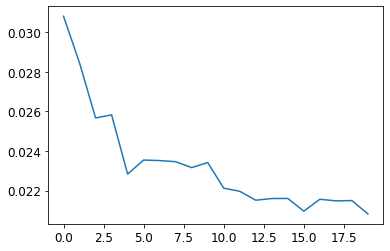

In [28]:
plt.plot(losses)
p

Compute scores of training data. 
* For each member_id, compute score for each destination. Rank destinations and compare against destinations actually travelled. 
* consider the 2016 data. For each user+user_attributes, cover a range of destinations. Each destination has its own destination attributes. 
Consider $n$ examples of destination attributes, compute a ranking of these $n$ items. There are 80 destinations and their attributes. Finally, 
there are attributes that are neither member destinations or desination attributes. 